In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
import PIL.Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
# from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from IPython.display import Image


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Input
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
from keras.layers.normalization import BatchNormalization
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras import optimizers

In [3]:
X_train=np.load('/content/drive/MyDrive/deep_learning_project/X_train.npy')
X_test=np.load('/content/drive/MyDrive/deep_learning_project/X_test.npy')
y_train=np.load('/content/drive/MyDrive/deep_learning_project/y_train.npy')
y_test=np.load('/content/drive/MyDrive/deep_learning_project/y_test.npy')

In [4]:
import random
index=list(range(len(y_train)))
idx=random.sample(index,8000)
X_train=X_train[idx]
y_train=y_train[idx]
X_train.shape

(8000, 224, 224, 3)

In [5]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
# base_model.summary()

17227776/17225924 [==============================] - 0s 0us/step


In [6]:
x=base_model.output
x=GlobalAveragePooling2D()(x)

# x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.

# x = Dropout(0.1)(x) # ****reduce dropout 

# x=Dense(1024,activation='relu')(x) #dense layer 2

# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

# x=Dense(512,activation='relu')(x) #dense layer 3

preds=Dense(10,activation='softmax')(x) #final layer with softmax activation

model = Model(base_model.input, preds)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, None, None, 32)    0     

In [7]:
from keras import optimizers  

#adam = optimizers.Adam(lr=0.001) #tried 0.0005 - too slow and didn't converge
sgd = optimizers.SGD(lr = 0.005) # try 0.01 - didn't converge and 0.005 , 0.001 best acc of 11%

model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy']) # create object

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('mobilenet_sgd_nolayers.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
mobilenet_model = model.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper],
                                                            epochs = 25, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/25
125/125 [==============================] - 1536s 12s/step - loss: 2.3578 - accuracy: 0.1666 - val_loss: 1.7059 - val_accuracy: 0.3858

Epoch 00001: val_loss improved from inf to 1.70592, saving model to mobilenet_sgd_nolayers.hdf5
Epoch 2/25
125/125 [==============================] - 1553s 12s/step - loss: 1.6140 - accuracy: 0.4679 - val_loss: 1.0596 - val_accuracy: 0.6512

Epoch 00002: val_loss improved from 1.70592 to 1.05962, saving model to mobilenet_sgd_nolayers.hdf5
Epoch 3/25
125/125 [==============================] - 1559s 12s/step - loss: 1.2046 - accuracy: 0.6234 - val_loss: 0.7183 - val_accuracy: 0.7666

Epoch 00003: val_loss improved from 1.05962 to 0.71833, saving model to mobilenet_sgd_nolayers.hdf5
Epoch 4/25
125/125 [==============================] - 1574s 13s/step - loss: 0.9760 - accuracy: 0.6917 - val_loss: 0.6567 - val_accuracy: 0.7725

Epoch 00004: val_loss improved from 0.71833 to 0.65666, saving model to mobilenet_sgd_nolayers.hdf5
Epoch 5/25
125/125 [

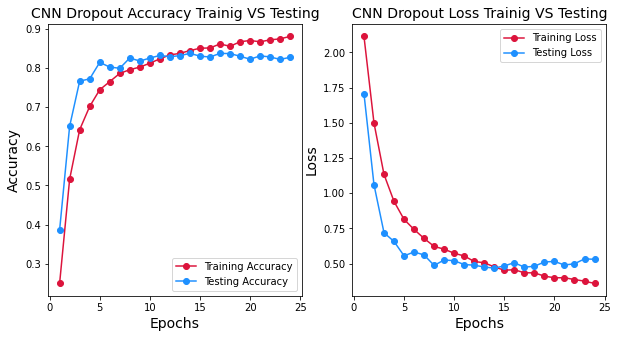

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(model.history.history['accuracy']) + 1), model.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(model.history.history['val_accuracy']) + 1), model.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(model.history.history['loss']) + 1), model.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(model.history.history['val_loss']) + 1), model.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')